In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchaudio import transforms
from torchvision.models import get_model
from torchmetrics.classification import MulticlassAUROC

from src.audio_utils import play_audio, plot_specgram, plot_waveform
from src.data import AudioDataset

/home/cedric/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = 'data'
train_dir = base_dir + '/train_audio/'
test_dir = base_dir + '/test_soundscapes/'
unlabeled_dir = base_dir + '/unlabeled_soundscapes/'

class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)
class_labels = list(range(n_classes))
label2name = dict(zip(class_labels, class_names))
name2label = {v:k for k,v in label2name.items()}

metadata = pd.read_csv(base_dir + '/train_metadata.csv')
metadata['filepath'] = train_dir + metadata.filename
metadata['target'] = metadata.primary_label.map(name2label)
metadata['filename'] = metadata.filepath.map(lambda x: x.split('/')[-1])
metadata['xc_id'] = metadata.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

In [30]:
aug_transforms = nn.Sequential(
    transforms.FrequencyMasking(freq_mask_param=80),
    transforms.TimeMasking(time_mask_param=80)
)

In [5]:
#train_df, valid_df = train_test_split(metadata, test_size=0.2)
train_df, valid_df = pd.read_csv('train_df.csv'), pd.read_csv('valid_df.csv')

print(f"Num Train: {len(train_df)}, {len(train_df['target'].unique())} classes |\
 Num Valid: {len(valid_df)}, {len(valid_df['target'].unique())} classes")

train_dataset = AudioDataset(train_df, n_classes=182)
val_dataset = AudioDataset(valid_df, n_classes=182)

Num Train: 19567, 182 classes | Num Valid: 4892, 182 classes


In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [7]:
class BasicClassifier(nn.Module):
    def __init__(self, n_classes) -> None:
        super(BasicClassifier, self).__init__()
        self.backbone = get_model('efficientnet_v2_s', weights='DEFAULT').features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2, inplace=True),
            nn.Linear(1280, n_classes)
            )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).squeeze()
        x = self.classifier(x)
        return x

In [8]:
device = torch.device('cuda')
num_epochs = 10

model = BasicClassifier(182).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_loader)),
                                                epochs=num_epochs,
                                                anneal_strategy='cos')
criterion = nn.CrossEntropyLoss()
metric = MulticlassAUROC(num_classes=182, average='macro', thresholds=5)

In [9]:
train_losses = []
val_losses = []
val_metrics = {'AUC': [], 'Accuracy': []}

for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    train_iter = tqdm(train_loader)
    for (batch, labels) in train_iter:
        optimizer.zero_grad()

        batch = batch.to(device)
        labels = labels.to(device)

        out = model(batch)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_iter.set_description(desc=f'train loss: {loss.item():.3f}')
        train_loss += loss.item() / len(train_loader)

    train_losses.append(train_loss)

    val_loss = 0
    #val_auc = 0
    val_accuracy = 0
    model.eval()
    val_iter = tqdm(val_loader)
    for (batch, labels) in val_iter:
        batch = batch.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            out = model(batch)
            loss = criterion(out, labels)

        val_loss += loss.item() / len(val_loader)
        #val_auc += metric(out, labels) / len(val_loader)
        pred = out.argmax(1)
        val_accuracy += ((pred == labels).sum() / len(labels)) / len(val_loader)

        val_iter.set_description(desc=f'val loss: {loss.item():.3f}')

    val_losses.append(val_loss)
    #val_metrics['AUC'].append(val_auc)
    val_metrics['Accuracy'].append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.3f} |\
          Val Loss = {val_loss:.3f}, Val Accuracy = {val_accuracy:.3f}')

val loss: 2.078: 100%|██████████| 153/153 [01:00<00:00,  2.54it/s]


Epoch 1: Train Loss = 4.003 |          Val Loss = 2.594, Val Accuracy = 0.425


val loss: 2.240: 100%|██████████| 153/153 [01:01<00:00,  2.48it/s]


Epoch 2: Train Loss = 2.272 |          Val Loss = 2.107, Val Accuracy = 0.520


val loss: 1.876: 100%|██████████| 153/153 [01:07<00:00,  2.27it/s]


Epoch 3: Train Loss = 1.911 |          Val Loss = 1.796, Val Accuracy = 0.583


val loss: 1.629: 100%|██████████| 153/153 [00:53<00:00,  2.88it/s]


Epoch 4: Train Loss = 1.580 |          Val Loss = 1.556, Val Accuracy = 0.637


val loss: 1.222: 100%|██████████| 153/153 [00:54<00:00,  2.83it/s]


Epoch 5: Train Loss = 1.337 |          Val Loss = 1.457, Val Accuracy = 0.670


val loss: 1.059: 100%|██████████| 153/153 [00:56<00:00,  2.71it/s]


Epoch 6: Train Loss = 1.121 |          Val Loss = 1.241, Val Accuracy = 0.713


val loss: 1.207: 100%|██████████| 153/153 [00:55<00:00,  2.75it/s]


Epoch 7: Train Loss = 0.907 |          Val Loss = 1.110, Val Accuracy = 0.743


val loss: 1.518: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]


Epoch 8: Train Loss = 0.696 |          Val Loss = 1.071, Val Accuracy = 0.763


val loss: 0.969: 100%|██████████| 153/153 [00:57<00:00,  2.64it/s]


Epoch 9: Train Loss = 0.551 |          Val Loss = 1.038, Val Accuracy = 0.768


val loss: 1.151: 100%|██████████| 153/153 [00:55<00:00,  2.78it/s]

Epoch 10: Train Loss = 0.467 |          Val Loss = 1.032, Val Accuracy = 0.770


In [10]:
save_dict = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "epoch": epoch+1,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_metrics": val_metrics
}

torch.save(save_dict, "checkpoints/efficientnet_v2_s_imagenet_base_32.pth")

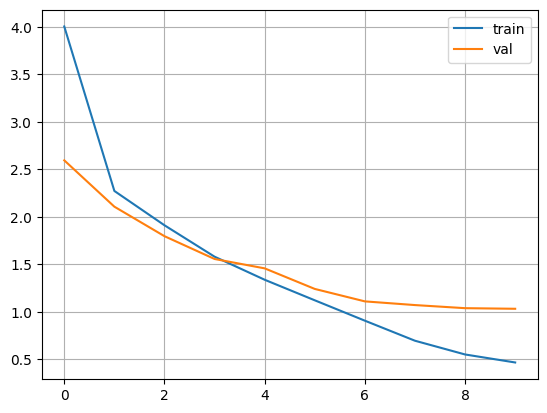

In [11]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.grid()
plt.legend()
plt.show()

In [22]:
labels

tensor([ 15, 125,  38, 132,  22,  71,  62,  37,  76,  14, 177,  38,  73, 143,
         45,  62, 129,  37,  41,  19, 108,  83,  77,  43, 110,  75,  98,  36,
         43, 148, 134, 105], device='cuda:0')

In [44]:
pred = out.argmax(1)
pred.shape

torch.Size([2])

In [47]:
(pred==labels).sum()

tensor(0)